In [1]:
# 1. Environment & Imports (with path setup)
import os, time, json, sys
from pathlib import Path

# Determine project root (parent of notebooks directory)
ROOT = Path.cwd().parent  # notebooks -> upreg_classify
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))  # ensure 'src' package import works

# Diagnostic: interpreter path
print('sys.executable:', sys.executable)
# Optional: verify path injection
print('Added to sys.path:', str(ROOT) in sys.path)
print('sys.path[0]:', sys.path[0])

from autogluon.tabular import TabularPredictor
# Import project training entry
from src.train.train import train_and_evaluate

DATA_RAW = ROOT / 'data' / 'raw'
DATA_PREPROCESSED = ROOT / 'data' / 'preprocessed'
CACHE_NO1 = DATA_PREPROCESSED / 'df_NO1.pkl'
MODELS_DIR = ROOT / 'models'
print('ROOT:', ROOT)
print('Data raw exists:', DATA_RAW.exists())
print('Preprocessed dir:', DATA_PREPROCESSED)
print('Cache NO1 exists:', CACHE_NO1.exists())
print('Models dir:', MODELS_DIR)

sys.executable: c:\PythonProjects\rl_reserve_markets\.venv1\Scripts\python.exe
Added to sys.path: True
sys.path[0]: C:\Users\haako\AppData\Local\Programs\Python\Python312\python312.zip
ROOT: c:\PythonProjects\rl_reserve_markets\upreg_classify
Data raw exists: True
Preprocessed dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\data\preprocessed
Cache NO1 exists: True
Models dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\models
ROOT: c:\PythonProjects\rl_reserve_markets\upreg_classify
Data raw exists: True
Preprocessed dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\data\preprocessed
Cache NO1 exists: True
Models dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\models


In [2]:
# 2. Utility wrapper
import importlib
from sklearn.metrics import classification_report
from autogluon.tabular import TabularPredictor

def reload_all():
    """Reload key project modules to pick up file changes without restarting VS Code."""
    print('--- Reloading project modules ---')
    import src.data.preprocess as dp
    import src.data.features as feat
    import src.train.hyperparameters as hp
    import src.train.train as tr
    importlib.reload(dp)
    importlib.reload(feat)
    importlib.reload(hp)
    importlib.reload(tr)
    # Re-export key symbols to current namespace if needed
    from src.train.train import train_and_evaluate as _tae
    globals()['train_and_evaluate'] = _tae
    print('Reloaded: preprocess, features, hyperparameters, train')


def run_training(description: str, **kwargs):
    """Run training via train_and_evaluate and report duration + key metrics.
    Required kwargs mirror train_and_evaluate parameters.
    This cell focuses on timing + metrics JSON only.
    """
    print(f'=== Run: {description} ===')
    start = time.time()
    metrics = train_and_evaluate(**kwargs)
    dur = time.time() - start
    print(f'Completed in {dur:.1f}s')
    print(json.dumps(metrics, indent=2))
    return metrics


def show_classification_reports(metrics: dict, output_dir: str):
    """Print validation + test classification reports in a separate cell.
    Call this after run_training(...) and pass its returned metrics and output_dir.
    """
    try:
        label = None
        if isinstance(metrics, dict):
            label = metrics.get('label') or metrics.get('label_col')
        if not (output_dir and label):
            print('Missing output_dir or label in metrics; cannot build reports.')
            return
        pred = TabularPredictor.load(output_dir)
        trainer = None
        try:
            trainer = pred._learner.load_trainer()
        except Exception:
            trainer = None

        # Validation report (if val_data retained)
        if trainer is not None and getattr(trainer, 'val_data', None) is not None:
            val_data = trainer.val_data
            if label in val_data.columns:
                y_true_val = val_data[label]
                X_val = val_data.drop(columns=[label])
                y_pred_val = pred.predict(X_val)
                print('Validation classification report:')
                print(classification_report(y_true_val, y_pred_val))
        else:
            print('No validation data available on trainer; skipping val report.')

        # Test report: use stored test CSV if train_and_evaluate recorded it
        test_csv = None
        if isinstance(metrics, dict):
            test_csv = metrics.get('test_csv') or metrics.get('test_path')
        if test_csv and os.path.exists(test_csv):
            import pandas as pd
            test_df = pd.read_csv(test_csv)
            if label in test_df.columns:
                y_true_test = test_df[label]
                X_test = test_df.drop(columns=[label])
                y_pred_test = pred.predict(X_test)
                print('\nTest classification report:')
                print(classification_report(y_true_test, y_pred_test))
        else:
            if not test_csv:
                print('No test_csv/test_path in metrics; skipping test report.')
            elif not os.path.exists(test_csv):
                print(f'Test CSV path not found: {test_csv}')
    except Exception as e:
        print('Could not generate classification reports:', e)


def base_common(area='NO1'):
    return dict(
        task='multiclass',
        area=area,
        data_dir=str(DATA_RAW),
        include_2024=True,
        heavy_interactions=False,
        dropna=True,
        train_frac=0.6, val_frac=0.2, test_frac=0.2,
        activation_lag_start=4,
        single_persistence=True,
        weight_factor_up=1.0, weight_factor_down=1.0, weight_factor_none=1.0,
        tune_up_bias=True, tune_up_objective='macro',
        num_bag_folds=0, num_stack_levels=0,
        importance_time_limit=60, importance_subsample=1200, importance_top_n=40,
        use_categorical_reglag=False,
        data_start=None,
    )

In [ ]:
# 3. Quick RF/XT priority baseline (NO1)
baseline_cfg = base_common(area='NO1')
baseline_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'baseline_rf_xt_priority'),
    time_limit=500,
    presets='best_quality',
    model_preset='rf_xt_priority',
    hpo_trials=0, hpo_searcher='random', hpo_scheduler='local',
))
# Uncomment to run
# run_training('Baseline RF/XT Priority NO1', **baseline_cfg)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.10 GB / 13.85 GB (22.4%)
Disk Space Avail:   371.93 GB / 952.62 GB (39.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.10 GB / 13.85 GB (22.4%)
Disk Space Avail:   371.93 GB / 952.62 GB (39.0%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1


=== Run: CatBoost-only HPO(4) NO1 ===
Loading preprocessed DataFrame from cache: c:\PythonProjects\rl_reserve_markets\upreg_classify\data\preprocessed\df_NO1.pkl
Dataset splits: train=37986, val=12662, test=12663 (total=63311)
Applied dataset start filter: from 2025-03-04 -> rows: 26360 (train 15816, val 5272, test 5272)
Last timestamp in dataset: 2025-12-03 14:45:00


Beginning AutoGluon training ... Time limit = 1000s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\cat_only_hpo4_no_bag"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\cat_only_hpo4_no_bag"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'Int8Dtype()' as a data type
	Available Memory:                    3166.47 MB
	Train Data (Original

Tuning up-multiplier alpha=0.75: F1(up)=0.0877, F1(macro)=0.4696
Tuning up-multiplier alpha=0.90: F1(up)=0.1535, F1(macro)=0.4919
Tuning up-multiplier alpha=1.00: F1(up)=0.2040, F1(macro)=0.5089
Tuning up-multiplier alpha=1.10: F1(up)=0.2322, F1(macro)=0.5185
Tuning up-multiplier alpha=1.18: F1(up)=0.2484, F1(macro)=0.5239
Tuning up-multiplier alpha=1.25: F1(up)=0.2783, F1(macro)=0.5343
Tuning up-multiplier alpha=1.30: F1(up)=0.2974, F1(macro)=0.5408
Tuning up-multiplier alpha=1.38: F1(up)=0.3174, F1(macro)=0.5476
Tuning up-multiplier alpha=1.45: F1(up)=0.3346, F1(macro)=0.5535
Tuning up-multiplier alpha=1.50: F1(up)=0.3385, F1(macro)=0.5545
Tuning up-multiplier alpha=1.75: F1(up)=0.3814, F1(macro)=0.5693
Tuning up-multiplier alpha=2.00: F1(up)=0.4090, F1(macro)=0.5788
Tuning up-multiplier alpha=2.50: F1(up)=0.4405, F1(macro)=0.5876
Tuning up-multiplier alpha=3.00: F1(up)=0.4603, F1(macro)=0.5921
Tuning up-multiplier alpha=3.50: F1(up)=0.4479, F1(macro)=0.5837
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['NO1-NO2_ratio_dup1', 'NO1-NO3_ratio_dup1', 'NO1-NO5_ratio_dup1', 'NO1-SE3_ratio_dup1', 'Persistency', 'PersistencyDown']
Computing feature importance via permutation shuffling for 93 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
Computing feature importance via permutation shuffling for 93 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	18.0s	= Expected runtime (1.8s per shuffle set)
	18.0s	= Expected runtime (1.8s per shuffle set)
	4.9s	= Actual runtime (Completed 10 of 10 shuffle sets)
	4.9s	= Actual runtime (Completed 10 of 10 shuffle sets)


Top feature importances:
  RegLag-4: 0.050017
  RegLag-5: 0.037977
  PersistenceUp: 0.027949
  PriceUp - DA: 0.024597
  RegLag-6: 0.020921
  PersistenceNone: 0.019199
  Up-Down Price Skew: 0.019059
  PriceUp/DA Ratio: 0.018085
  PersistenceDown: 0.015150
  Price Symm Rel Diff: 0.014789
  Consumption / Production: 0.013840
  PriceDown - DA: 0.012200
  RegLag-7: 0.011173
  DA/ID Price Ratio: 0.010148
  DA Price: 0.010048
  RegLag-9: 0.008576
  NO1-NO5_ratio: 0.008484
  Accepted Up Share: 0.006812
  PriceUp_t-1: 0.006242
  mFRR Cap Up Quantity Lag-6: 0.005965
  Accepted Imbalance Ratio: 0.005888
  mFRR Cap Down Price: 0.005194
  hour_cos: 0.004917
  Consumption: 0.004851
  NO1-SE3_ratio: 0.004315
  RegLag-12: 0.004262
  aFRR_Persistency: 0.003907
  RegLag-10: 0.003898
  Residual Load: 0.003766
  mFRR Cap Down Quantity Lag-2: 0.003579
  mFRR Cap Down Quantity Lag-9: 0.003359
  RegLag-8: 0.003048
  mFRR Cap Down Quantity Lag-3: 0.002828
  aFRR Up Quantity: 0.002816
  Wind Share: 0.002762
  

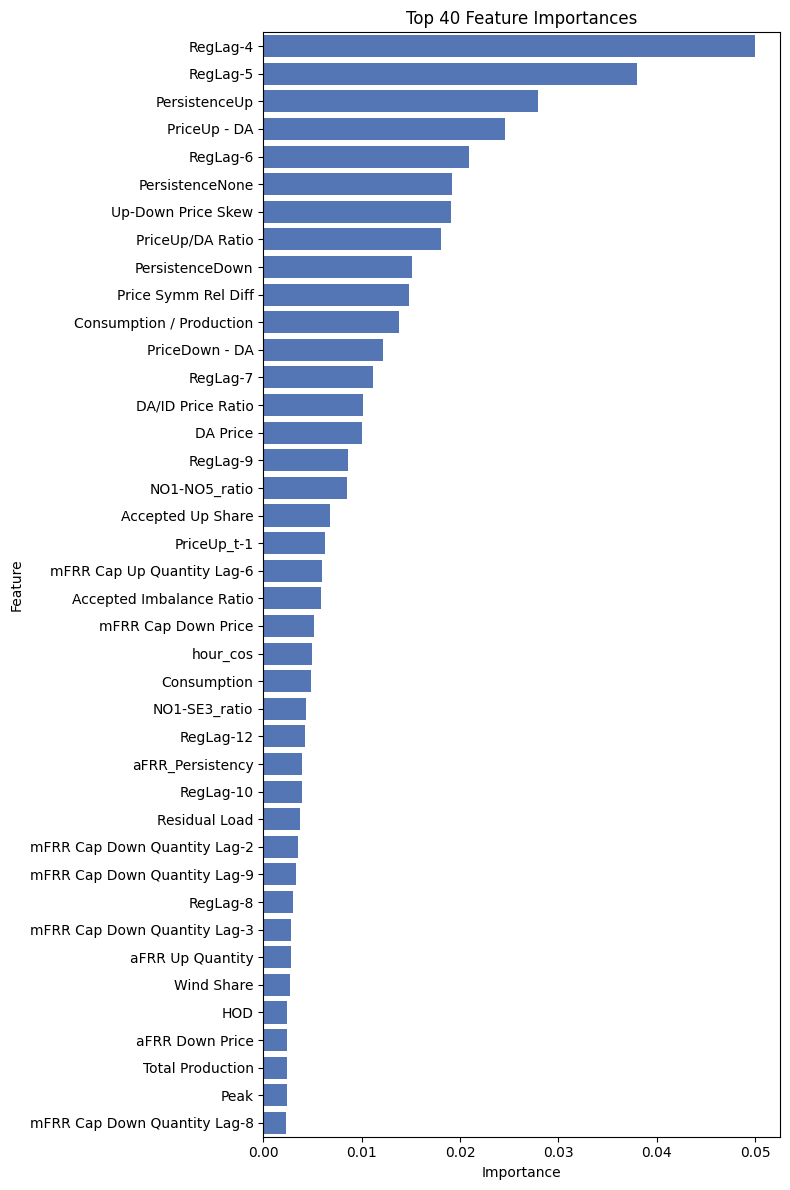

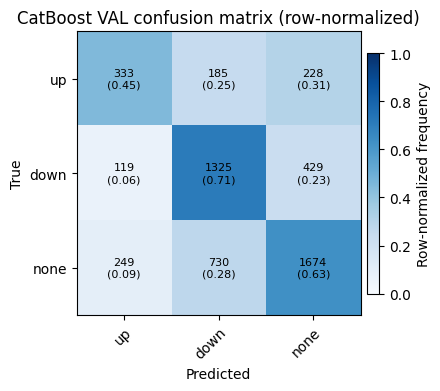

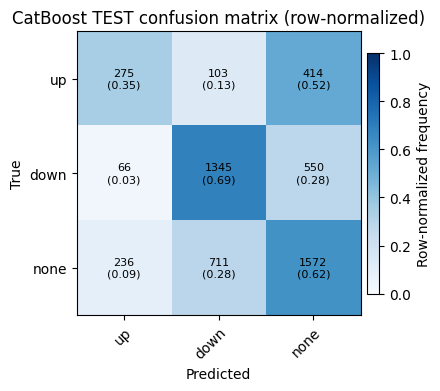

negatives in UP spread: 0
positives in DOWN spread: 0
                                               name    n       mean       std        min        p05        p25       p50       p75       p95        max
              Up Price - DA | correct UP (delivery)  275  17.980291 14.329015    0.12000   1.808000   6.320000 15.820000 25.815000 40.046000 100.440000
          Down Price - DA | correct DOWN (delivery) 1343 -12.336895 16.776066 -161.33000 -39.666000 -11.835000 -7.660000 -5.540000 -1.920000  -0.030000
UP % change vs DA | correct UP (delivery) [percent]  232  25.138040 25.849795    0.14331   2.199907   7.036025 19.800458 35.737656 62.583001 247.633136


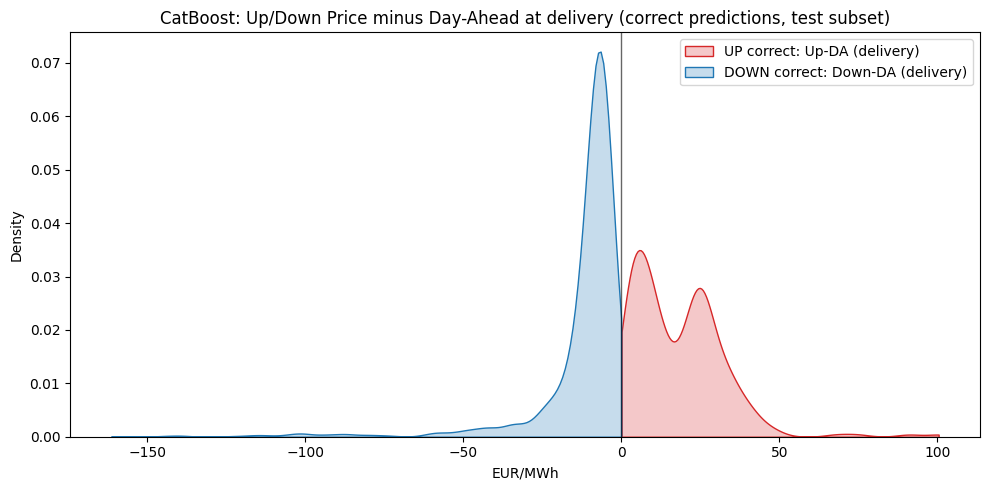


CatBoost transition table Prev(t-4 class) to Pred(t+4 class) [test subset, tuned up-bias]:
Predicted class at t+4   up  down  none
Prev class at t-4                      
up                      445    91   256
down                     26  1796   136
none                    106   272  2144

Cell-wise accuracy given (prev_class, predicted_class):
            up      down      none
up    0.552809  0.428571  0.535156
down  0.192308  0.654232  0.661765
none  0.226415  0.481618  0.627332


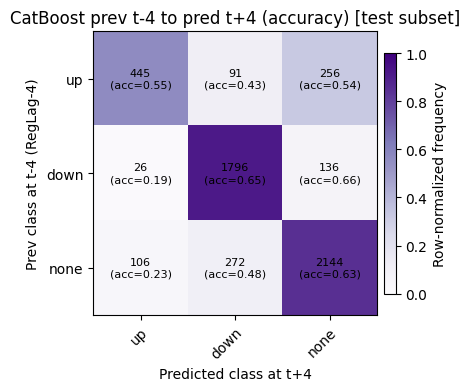

In [3]:
# 4. CatBoost-only + HPO trials (NO1)
cat_hpo_cfg = base_common(area='NO1')
cat_hpo_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'cat_only_hpo4_no_bag'),
    time_limit=1000,
    presets='best_quality',
    model_preset='cat_only',
    data_start='2025-03-04',
    # Use cached preprocessing (created via scripts/preprocess_cache.py)
    preprocessed_path=str(CACHE_NO1),
    #only_persistency_features=True
    #exclude_persistency_features=True
))

# Run training and capture metrics so we can inspect transitions later
cat_hpo_metrics = run_training('CatBoost-only HPO(4) NO1', **cat_hpo_cfg)

# After training: evaluate on a consistent time-based test split and show transitions
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from sklearn.metrics import classification_report, confusion_matrix

import src.data.preprocess as dp
from src.data.preprocess import Config
from src.evaluation.evaluation import _predict_labels_with_policy
from src.evaluation.price_spread import plot_imbalance_vs_spot_price

label = None
if isinstance(cat_hpo_metrics, dict):
    label = cat_hpo_metrics.get('label') or cat_hpo_metrics.get('label_col')
if label is None:
    label = 'RegClass+4'  # sensible default

# 1) Load the full preprocessed dataframe from cache (or build it if cache missing)
cfg = Config()
df_full = dp.preprocess_all(cfg=cfg, cache_path=str(CACHE_NO1))
df_full = df_full.loc['2025-03-04':]
print('CatBoost diagnostics using data range:', df_full.index.min(), '->', df_full.index.max(), 'rows =', len(df_full))

# 2) Apply the same 0.6/0.2/0.2 chronological split used elsewhere
n = len(df_full)
val_start = int(n * 0.6)
test_start = int(n * 0.8)
df_val = df_full.iloc[val_start:test_start]
df_test = df_full.iloc[test_start:]
print('Validation subset rows for CatBoost diagnostics =', len(df_val))
print('Test subset rows for CatBoost diagnostics =', len(df_test))

if label not in df_test.columns:
    raise KeyError(f'Test subset missing label column {label}; cannot evaluate CatBoost.')
if 'RegLag-4' not in df_test.columns:
    raise KeyError("Test subset missing 'RegLag-4'; cannot build transition table.")

# 3) Use the trained CatBoost model to predict on this val/test subsets
pred_cat = TabularPredictor.load(cat_hpo_cfg['output_dir'])
X_val = df_val.drop(columns=[label])
y_true_val = df_val[label].astype(str)
X_test = df_test.drop(columns=[label])
y_true_test = df_test[label].astype(str)

# Load tuned up-bias policy from training, if available
policy = None
cm_path = Path(cat_hpo_cfg['output_dir']) / 'class_multipliers.json'
if cm_path.exists():
    try:
        with open(cm_path, 'r', encoding='utf-8') as f:
            cm_data = json.load(f)
        alpha = cm_data.get('up')
        if alpha is not None:
            policy = {'type': 'multiplier', 'up': float(alpha)}
            print(f'Using tuned up-bias policy with alpha={alpha:.3f}')
    except Exception as e:
        print('Could not load class_multipliers.json, falling back to raw predictions:', e)

# Predict using tuned policy if present (otherwise raw predictor outputs)
y_pred_val = _predict_labels_with_policy(pred_cat, X_val, policy).astype(str)
y_pred_test = _predict_labels_with_policy(pred_cat, X_test, policy).astype(str)

# Alias test variables for downstream transition analysis
y_true = y_true_test
y_pred = y_pred_test

labels_order = ['down', 'none', 'up']
cm_labels = ['up', 'down', 'none']

print('\n=== VAL Classification Report ===')
print(classification_report(y_true_val, y_pred_val, labels=labels_order))
cm_val = confusion_matrix(y_true_val, y_pred_val, labels=cm_labels)
print('\n=== VAL Confusion Matrix ===')
print('Labels: ' + ', '.join(cm_labels))
print(cm_val)

print('\n=== TEST Classification Report ===')
print(classification_report(y_true_test, y_pred_test, labels=labels_order))
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels)
print('\n=== TEST Confusion Matrix ===')
print('Labels: ' + ', '.join(cm_labels))
print(cm_test)

# 3b) Visual confusion matrices (row-normalized) for VAL and TEST
labels_cm_plot = cm_labels

# Validation confusion matrix heatmap
cm_val_sum = cm_val.sum(axis=1, keepdims=True)
cm_val_norm = np.divide(cm_val.astype(float), cm_val_sum, where=cm_val_sum != 0)
fig, ax = plt.subplots(figsize=(4.5, 4.0))
im = ax.imshow(cm_val_norm, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('Row-normalized frequency')
ax.set_title('CatBoost VAL confusion matrix (row-normalized)')
ax.set_xticks(range(len(labels_cm_plot)))
ax.set_yticks(range(len(labels_cm_plot)))
ax.set_xticklabels(labels_cm_plot)
ax.set_yticklabels(labels_cm_plot)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
for i in range(len(labels_cm_plot)):
    for j in range(len(labels_cm_plot)):
        count = cm_val[i, j]
        frac = cm_val_norm[i, j]
        text = f"{count}\n({frac:.2f})"
        ax.text(j, i, text, ha='center', va='center', color='black', fontsize=8)
fig.tight_layout()
plt.show()

# Test confusion matrix heatmap
cm_test_sum = cm_test.sum(axis=1, keepdims=True)
cm_test_norm = np.divide(cm_test.astype(float), cm_test_sum, where=cm_test_sum != 0)
fig, ax = plt.subplots(figsize=(4.5, 4.0))
im = ax.imshow(cm_test_norm, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('Row-normalized frequency')
ax.set_title('CatBoost TEST confusion matrix (row-normalized)')
ax.set_xticks(range(len(labels_cm_plot)))
ax.set_yticks(range(len(labels_cm_plot)))
ax.set_xticklabels(labels_cm_plot)
ax.set_yticklabels(labels_cm_plot)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
for i in range(len(labels_cm_plot)):
    for j in range(len(labels_cm_plot)):
        count = cm_test[i, j]
        frac = cm_test_norm[i, j]
        text = f"{count}\n({frac:.2f})"
        ax.text(j, i, text, ha='center', va='center', color='black', fontsize=8)
fig.tight_layout()
plt.show()

# 3c) Price spread vs Day-Ahead at delivery (correct predictions)
preds_test_df = pd.DataFrame({label: y_true_test, 'pred': y_pred_test}, index=df_test.index)
preds_test_df.index.name = 'Time'
fig_price, ax_price, res_price, stats_price = plot_imbalance_vs_spot_price(
    preds=preds_test_df,
    data_raw_dir=str(DATA_RAW),
    area='NO1',
    horizon_steps=4,
    include_2024=True,
    min_da_price=20.0,
    label_col=label,
    title='CatBoost: Up/Down Price minus Day-Ahead at delivery (correct predictions, test subset)',
    bw_adjust=0.8,
    print_stats=True,
 )
plt.show()

# Show the stats table explicitly as a DataFrame output as well
stats_price['summary']

# 4) Build transitions: previous class at t-4 (from RegLag-4) to predicted class at t+4
prev_numeric = df_test['RegLag-4']
dir_to_class = {1: 'up', -1: 'down', 0: 'none'}
prev_class = prev_numeric.map(dir_to_class).astype(str)

row_order = ['up', 'down', 'none']
col_order = ['up', 'down', 'none']

trans_ct = pd.crosstab(prev_class, y_pred,
                        rownames=['Prev class at t-4'],
                        colnames=['Predicted class at t+4'])
trans_ct = trans_ct.reindex(index=row_order, columns=col_order, fill_value=0)

print('\nCatBoost transition table Prev(t-4 class) to Pred(t+4 class) [test subset, tuned up-bias]:')
print(trans_ct)

# Row-normalized version for visualization (how predictions distribute across next-classes)
trans_row_pct = trans_ct.div(trans_ct.sum(axis=1), axis=0).fillna(0.0)

# Cell-wise accuracy: among rows with given prev_class & predicted_class, how often was it correct?
cell_acc = pd.DataFrame(index=row_order, columns=col_order, dtype=float)
for r in row_order:
    for c in col_order:
        mask = (prev_class == r) & (y_pred == c)
        total = mask.sum()
        if total == 0:
            cell_acc.loc[r, c] = np.nan
        else:
            correct = (y_true[mask] == c).sum()
            cell_acc.loc[r, c] = correct / float(total)

print('\nCell-wise accuracy given (prev_class, predicted_class):')
print(cell_acc)

# Plot heatmap (distinct colormap from confusion matrices)
fig, ax = plt.subplots(figsize=(4.5, 4.0))
im = ax.imshow(trans_row_pct.values, interpolation='nearest', cmap='Purples', vmin=0.0, vmax=1.0)
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('Row-normalized frequency')

ax.set_title('CatBoost prev t-4 to pred t+4 (accuracy) [test subset]')
ax.set_xticks(range(len(col_order)))
ax.set_yticks(range(len(row_order)))
ax.set_xticklabels(col_order)
ax.set_yticklabels(row_order)
ax.set_xlabel('Predicted class at t+4')
ax.set_ylabel('Prev class at t-4 (RegLag-4)')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotate each cell with count and cell-wise accuracy
for i, r in enumerate(row_order):
    for j, c in enumerate(col_order):
        count = trans_ct.iloc[i, j]
        acc = cell_acc.loc[r, c]
        if np.isnan(acc):
            text = f"{count}\n(n/a)"
        else:
            text = f"{count}\n(acc={acc:.2f})"
        ax.text(j, i, text, ha='center', va='center', color='black', fontsize=8)

fig.tight_layout()
plt.show()

=== Run: Baseline RF/XT Priority NO2 ===
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
mFRR capacity data shape: (64317, 31)
flows shape: (67584, 8)
Number of NaNs before dropna: 139412
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
mFRR capacity data s

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.48 GB / 13.85 GB (17.9%)
Disk Space Avail:   370.90 GB / 952.62 GB (38.9%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.48 GB / 13.85 GB (17.9%)
Disk Space Avail:   370.90 GB / 952.62 GB (38.9%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1


Final preprocessed DataFrame shape: (63311, 100)
Dataset splits: train=37986, val=12662, test=12663 (total=63311)
Applied dataset start filter: from 2025-03-04 -> rows: 26360 (train 15816, val 5272, test 5272)
Last timestamp in dataset: 2025-12-03 14:45:00


Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\baseline_rf_xt_priority_NO2"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\baseline_rf_xt_priority_NO2"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'Int8Dtype()' as a data type
	Available Memory:                    2516.50 MB
	Train D

Tuning up-multiplier alpha=0.75: F1(up)=0.3462, F1(macro)=0.5635
Tuning up-multiplier alpha=0.90: F1(up)=0.3775, F1(macro)=0.5729
Tuning up-multiplier alpha=1.00: F1(up)=0.4111, F1(macro)=0.5834
Tuning up-multiplier alpha=1.10: F1(up)=0.4225, F1(macro)=0.5858
Tuning up-multiplier alpha=1.18: F1(up)=0.4299, F1(macro)=0.5867
Tuning up-multiplier alpha=1.25: F1(up)=0.4363, F1(macro)=0.5866
Tuning up-multiplier alpha=1.30: F1(up)=0.4350, F1(macro)=0.5835
Tuning up-multiplier alpha=1.38: F1(up)=0.4381, F1(macro)=0.5824
Tuning up-multiplier alpha=1.45: F1(up)=0.4367, F1(macro)=0.5781
Tuning up-multiplier alpha=1.50: F1(up)=0.4330, F1(macro)=0.5747
Tuning up-multiplier alpha=1.75: F1(up)=0.4292, F1(macro)=0.5614
Tuning up-multiplier alpha=2.00: F1(up)=0.4069, F1(macro)=0.5361
Tuning up-multiplier alpha=2.50: F1(up)=0.3586, F1(macro)=0.4767
Tuning up-multiplier alpha=3.00: F1(up)=0.3356, F1(macro)=0.4212
Tuning up-multiplier alpha=3.50: F1(up)=0.3191, F1(macro)=0.3823
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['NO1-NO2_ratio_dup1', 'NO1-NO3_ratio_dup1', 'NO1-NO5_ratio_dup1', 'NO1-SE3_ratio_dup1', 'Persistency', 'PersistencyDown']
Computing feature importance via permutation shuffling for 93 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
Computing feature importance via permutation shuffling for 93 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	773.22s	= Expected runtime (77.32s per shuffle set)
	773.22s	= Expected runtime (77.32s per shuffle set)
	55.52s	= Actual runtime (Completed 8 of 10 shuffle sets) (Early stopping due to lack of time...)
	55.52s	= Actual runtime (Completed 8 of 10 shuffle sets) (Early stopping due to lack of time...)


Top feature importances:
  Import/Consumption: 0.021367
  RegLag-4: 0.021353
  PersistenceNone: 0.020337
  PersistenceUp: 0.018055
  DA Price: 0.012412
  RegLag-5: 0.011772
  PriceDown - DA: 0.011557
  PriceUp - DA: 0.011018
  hour_sin: 0.009826
  RegLag-11: 0.008518
  RegLag-6: 0.007847
  RegLag-13: 0.007429
  NO1-SE3_ratio: 0.007005
  Up-Down Price Skew: 0.006968
  aFRR Up Quantity: 0.006847
  NO1-NO5_ratio: 0.006844
  mFRR Cap Down Quantity Lag-5: 0.006841
  mFRR Cap Quantity Lag-9: 0.006829
  PriceUp/DA Ratio: 0.006764
  Total Production: 0.006743
  PersistenceDown: 0.006340
  mFRR Cap Up Quantity Lag-8: 0.006336
  RegLag-9: 0.006272
  mFRR Cap Quantity Lag-3: 0.006165
  Price Symm Rel Diff: 0.006069
  hour_cos: 0.006034
  RegLag-7: 0.006003
  Peak: 0.005930
  DA/ID Price Ratio: 0.005627
  PriceUp_t-1: 0.005621
  mFRR Cap Down Quantity Lag-1: 0.005395
  PriceDown/DA Ratio: 0.005294
  mFRR Cap Down Quantity Lag-7: 0.005033
  mFRR Cap Down Quantity Lag-9: 0.004916
  HOD: 0.004883
  m

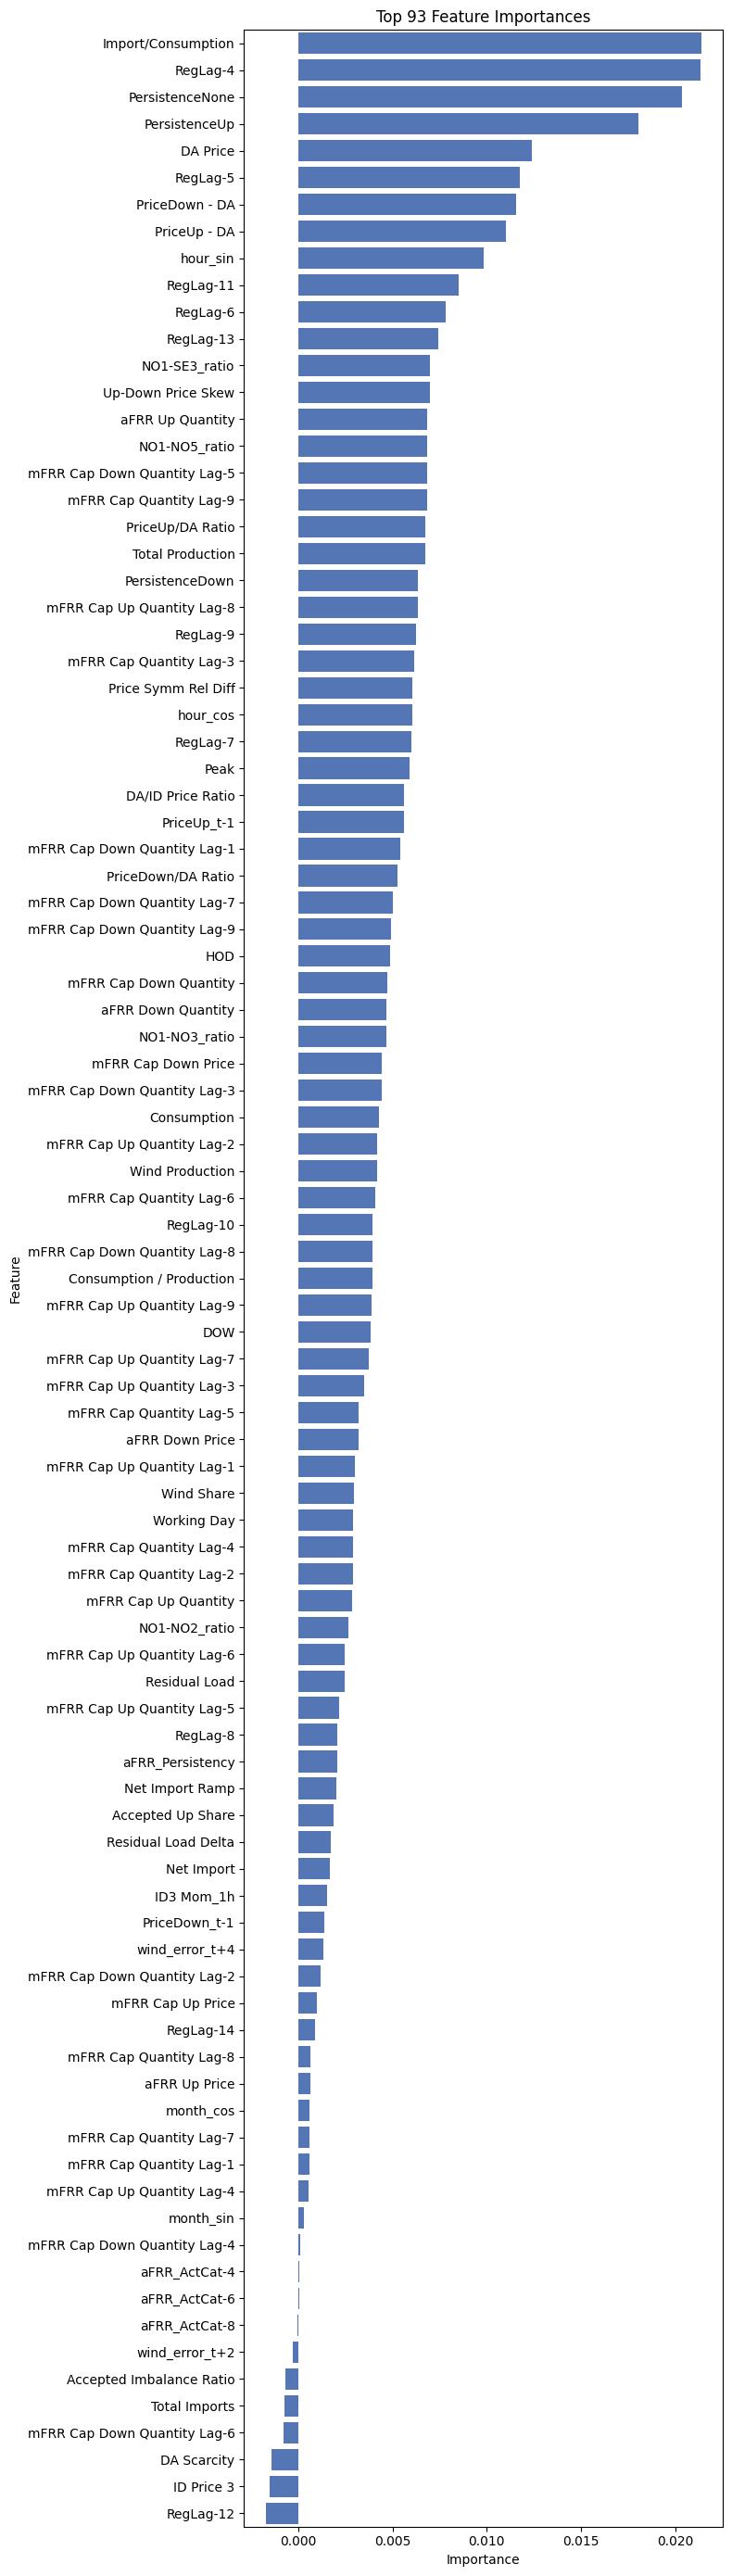

In [8]:
# 5. Baseline RF/XT priority for NO2 (area switch)
no2_baseline_cfg = base_common(area='NO1')
no2_baseline_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'baseline_rf_xt_priority_NO2'),
    time_limit=120,
    presets='best_quality',
    model_preset='rf_xt_priority',
    data_start= '2025-03-04',
    hpo_trials=0, hpo_searcher='random', hpo_scheduler='local',
))
# Uncomment to run
run_training('Baseline RF/XT Priority NO2', **no2_baseline_cfg)

In [ ]:
# 6. Stacking example (rf_xt_boost_stack) with modest time limit
stack_cfg = base_common(area='NO1')
stack_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'stack_rf_xt_boost'),
    time_limit=300,
    presets='best_quality',
    model_preset='rf_xt_boost_stack',
    num_bag_folds=0, num_stack_levels=0,  # keep disabled per requirement
    hpo_trials=0,
))
# Uncomment to run
run_training('Stack Config (no actual bag/stack) NO1', **stack_cfg)

In [ ]:
# 7. Batch runner: choose which configs to execute in sequence
batch = [
    # ('Baseline NO1', baseline_cfg),
    # ('CatBoost HPO4 NO1', cat_hpo_cfg),
    # ('Baseline NO2', no2_baseline_cfg),
]
results = {}
for name, cfg in batch:
    metrics = run_training(name, **cfg)
    results[name] = metrics
if results:
    print('Summary (macro F1):', {k: v.get('val_f1_macro') for k, v in results.items()})

### Notes
- Increase `time_limit` substantially (e.g., 1800+) for higher quality models.
- Set class weighting (e.g., `weight_factor_up=1.3`) to emphasize minority classes.
- Enable categorical RegLag features via `use_categorical_reglag=True` if desired.
- For persistence across re-runs, choose distinct `output_dir` names.

In [ ]:
# XGBoost-only (no HPO) sanity run
xgb_cfg = base_common(area='NO1')
xgb_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_baseline_light'),
    time_limit=180,
    presets='medium_quality',
    model_preset='xgb_only',
    hpo_trials=0,               # disable HPO to isolate training
    hpo_searcher='random',
    hpo_scheduler='local',
    #data_start='2025-06-01',    # keep subset for speed
))
run_training('XGBoost-only BASELINE NO1 LIGHT', **xgb_cfg)


=== Run: XGBoost-only FULL FIXED VARIANTS NO1 ===
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
mFRR capacity data shape: (64317, 31)
flows shape: (67584, 8)
Number of NaNs before dropna: 139412
Final preprocessed DataFrame shape: (63311, 100)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (6

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       0.86 GB / 13.85 GB (6.2%)
Disk Space Avail:   368.76 GB / 952.62 GB (38.7%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       0.86 GB / 13.85 GB (6.2%)
Disk Space Avail:   368.76 GB / 952.62 GB (38.7%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1


Dataset splits: train=37986, val=12662, test=12663 (total=63311)
Applied dataset start filter: from 2025-03-04 -> rows: 26360 (train 15816, val 5272, test 5272)
Last timestamp in dataset: 2025-12-03 14:45:00


Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\xgb_only_full_fixed_actual"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\xgb_only_full_fixed_actual"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'Int8Dtype()' as a data type
Cannot interpret 'Int8Dtype()' as a data type
	Available M

Tuning up-multiplier alpha=0.75: F1(up)=0.0000, F1(macro)=0.4213
Tuning up-multiplier alpha=0.90: F1(up)=0.0000, F1(macro)=0.4213
Tuning up-multiplier alpha=1.00: F1(up)=0.2622, F1(macro)=0.5064
Tuning up-multiplier alpha=1.10: F1(up)=0.2498, F1(macro)=0.1044
Tuning up-multiplier alpha=1.18: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.25: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.30: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.38: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.45: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.25: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.30: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.38: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.45: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.50: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alpha=1.75: F1(up)=0.2479, F1(macro)=0.0826
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['NO1-NO2_ratio_dup1', 'NO1-NO3_ratio_dup1', 'NO1-NO5_ratio_dup1', 'NO1-SE3_ratio_dup1', 'Persistency', 'PersistencyDown']
Computing feature importance via permutation shuffling for 93 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
Computing feature importance via permutation shuffling for 93 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	136.51s	= Expected runtime (13.65s per shuffle set)
	136.51s	= Expected runtime (13.65s per shuffle set)
	17.26s	= Actual runtime (Completed 10 of 10 shuffle sets)
	17.26s	= Actual runtime (Completed 10 of 10 shuffle sets)


Top feature importances:
  PersistenceNone: 0.045703
  DA Price: 0.042997
  RegLag-4: 0.038231
  PersistenceDown: 0.027197
  mFRR Cap Down Quantity Lag-9: 0.021805
  PriceDown - DA: 0.016416
  PriceUp_t-1: 0.011917
  HOD: 0.011636
  hour_sin: 0.011151
  mFRR Cap Down Price: 0.010382
  Up-Down Price Skew: 0.008487
  wind_error_t+4: 0.006510
  PriceUp - DA: 0.005479
  Consumption: 0.005319
  mFRR Cap Down Quantity Lag-4: 0.005262
  Price Symm Rel Diff: 0.004955
  RegLag-10: 0.004238
  Residual Load: 0.003862
  mFRR Cap Up Quantity Lag-6: 0.003714
  mFRR Cap Down Quantity Lag-6: 0.003528
  RegLag-8: 0.003299
  NO1-NO5_ratio: 0.002997
  mFRR Cap Down Quantity Lag-8: 0.002604
  RegLag-7: 0.002554
  Wind Share: 0.002223
  mFRR Cap Up Price: 0.002199
  PriceDown/DA Ratio: 0.002131
  aFRR Down Quantity: 0.002011
  Consumption / Production: 0.001945
  Wind Production: 0.001819
  mFRR Cap Up Quantity Lag-7: 0.001713
  Total Production: 0.001599
  DOW: 0.001511
  Accepted Up Share: 0.001314
  NO1

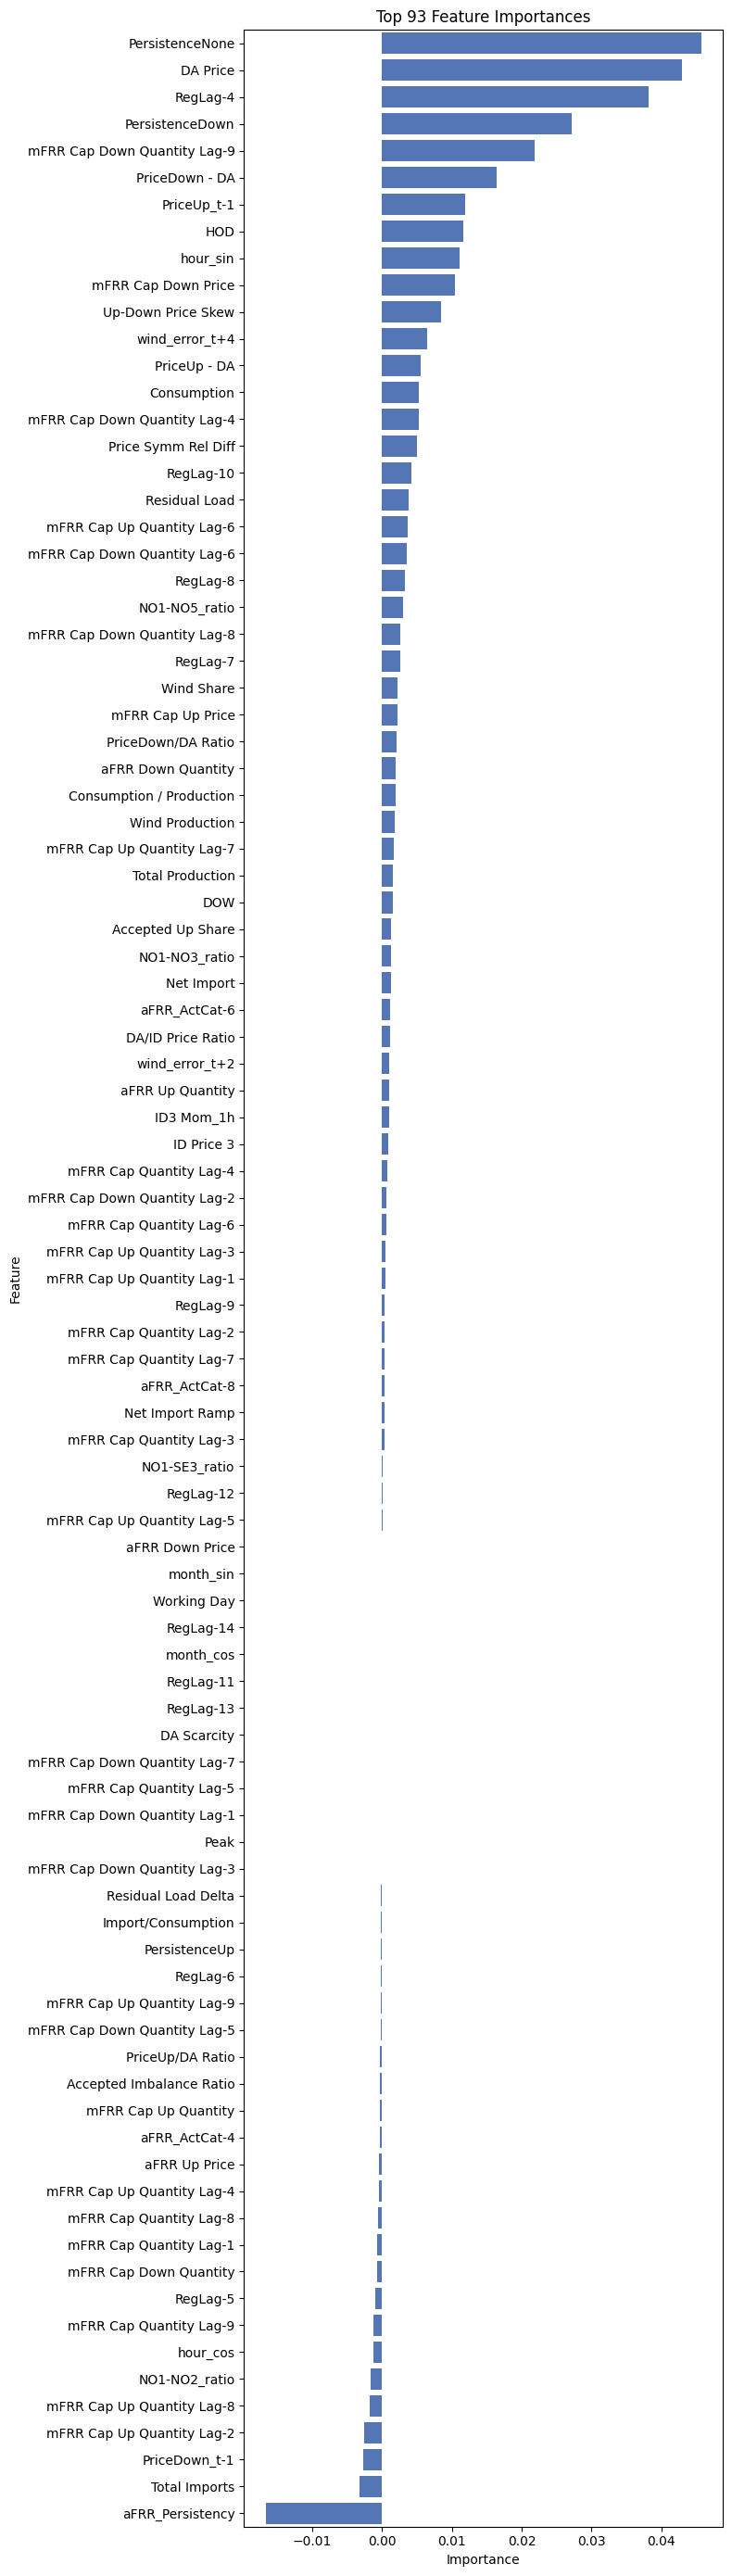

In [11]:
# 8. XGBoost-only FULL run (fixed variants, full data)
xgb_full_cfg = base_common(area='NO1')
xgb_full_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_full_fixed_actual'),
    time_limit=1800,             # 30 minutes budget; adjust as needed
    presets='best_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=5,                # no HPO; use fixed variants
    hpo_searcher='random',
    hpo_scheduler='local',
    data_start='2025-03-04',             # ensure full dataset
))
run_training('XGBoost-only FULL FIXED VARIANTS NO1', **xgb_full_cfg)

In [ ]:
# 10. Inspect trained model families from saved predictors
from autogluon.tabular import TabularPredictor
paths = [
    MODELS_DIR / 'xgb_only_full_fixed',
    MODELS_DIR / 'xgb_only_full_fixed_actual',
    MODELS_DIR / 'xgb_only_full_hpo6',
    MODELS_DIR / 'xgb_only_full_hpo2_quick',
]
for p in paths:
    p = str(p)
    if Path(p).exists():
        try:
            pred = TabularPredictor.load(p)
            print(f'Path: {p}')
            print('Models:', pred.model_names())
        except Exception as e:
            print(f'Failed to load {p}:', e)


In [ ]:
# 11. Force-reload training modules to pick up latest hyperparameter presets
import importlib
import src.train.hyperparameters as hp
import src.train.train as tr
hp = importlib.reload(hp)
tr = importlib.reload(tr)
from src.train.hyperparameters import build_hyperparameters
print('xgb_only_fixed keys:', list(build_hyperparameters('xgb_only_fixed', hpo_trials=0).keys()))


In [ ]:
# 12. Sanity: XGBoost-only FIXED on subset, verify model families
xgb_subset_cfg = base_common(area='NO1')
xgb_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_only_fixed_subset_check'),
    time_limit=1000,
    presets='best_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=5,
    data_start='2025-03-04',
))
metrics = run_training('XGB FIXED SUBSET CHECK', **xgb_subset_cfg)
# Show trained models
pred = TabularPredictor.load(xgb_subset_cfg['output_dir'])
print('Models:', pred.model_names())


In [ ]:
# 13. Sanity: CatBoost-only on subset, mirror cfg of #12
from src.train.train import train_and_evaluate
reload_all()
cat_subset_cfg = base_common(area='NO1')
cat_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'cat_only_subset_check'),
    time_limit=600,
    presets='best_quality',
    model_preset='cat_only',
    hpo_trials=2,
    data_start='2025-03-04',
))
metrics = run_training('CAT ONLY SUBSET CHECK', **cat_subset_cfg)
# Show trained models
pred = TabularPredictor.load(cat_subset_cfg['output_dir'])
print('Models:', pred.model_names())


In [ ]:
# 14. Sanity: LightGBM-only on subset, mirror cfg of #12
lgbm_subset_cfg = base_common(area='NO1')
lgbm_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'lgbm_only_subset_check'),
    time_limit=1000,
    presets='best_quality',
    model_preset='lgbm_only',
    hpo_trials=0,
    data_start='2025-03-04',
))
metrics = run_training('LGBM ONLY SUBSET CHECK', **lgbm_subset_cfg)
# Show trained models
pred = TabularPredictor.load(lgbm_subset_cfg['output_dir'])
print('Models:', pred.model_names())


In [ ]:
# 15. Subset run with persistency interactions disabled (XGB fixed)
xgb_no_inter_subset_cfg = base_common(area='NO1')
xgb_no_inter_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'xgb_fixed_subset_no_interactions'),
    time_limit=600,
    presets='medium_quality',
    model_preset='xgb_only_fixed',
    hpo_trials=0,
    data_start='2025-03-04',
    disable_persistency_interactions=True,
))
metrics = run_training('XGB FIXED SUBSET NO INTERACTIONS', **xgb_no_inter_subset_cfg)
# Show trained models
pred = TabularPredictor.load(xgb_no_inter_subset_cfg['output_dir'])
print('Models:', pred.model_names())


=== Run: LGBM ONLY HPO(4) SUBSET CHECK ===
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
mFRR capacity data shape: (64317, 31)
flows shape: (67584, 8)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
mFRR capacity data shape: (64317, 31)
flows shape: (675

Verbosity: 2 (Standard Logging)
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.89 GB / 13.85 GB (20.9%)
Disk Space Avail:   355.59 GB / 952.62 GB (37.3%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.89 GB / 13.85 GB (20.9%)
Disk Space Avail:   355.59 GB / 952.62 GB (37.3%)
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=1


Number of NaNs before dropna: 139412
Final preprocessed DataFrame shape: (63311, 100)
Dataset splits: train=37986, val=12662, test=12663 (total=63311)
Applied dataset start filter: from 2025-03-04 -> rows: 26360 (train 15816, val 5272, test 5272)
Last timestamp in dataset: 2025-12-03 14:45:00


Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\lgbm_only_subset_hpo"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\lgbm_only_subset_hpo"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'Int8Dtype()' as a data type
	Available Memory:                    2937.96 MB
	Train Data (Original)  Memory Usage: 15.10 MB (0.5% of availabl

  0%|          | 0/4 [00:00<?, ?it/s]

Fitted model: LightGBM\T1 ...
	0.4516	 = Validation score   (f1_macro)
	5.96s	 = Training   runtime
	0.07s	 = Validation runtime
	0.4516	 = Validation score   (f1_macro)
	5.96s	 = Training   runtime
	0.07s	 = Validation runtime
Fitted model: LightGBM\T2 ...
	0.4324	 = Validation score   (f1_macro)
	4.52s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM\T2 ...
	0.4324	 = Validation score   (f1_macro)
	4.52s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM\T3 ...
	0.4263	 = Validation score   (f1_macro)
	4.63s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM\T3 ...
	0.4263	 = Validation score   (f1_macro)
	4.63s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM\T4 ...
	0.457	 = Validation score   (f1_macro)
	3.26s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM\T4 ...
	0.457	 = Validation score   (f1_macro)
	3.26s	 = Training   runtime
	0.01s	 = Validation runtime


Tuning up-multiplier alpha=0.75: F1(up)=0.0079, F1(macro)=0.4271
Tuning up-multiplier alpha=0.90: F1(up)=0.0608, F1(macro)=0.4454
Tuning up-multiplier alpha=1.00: F1(up)=0.1034, F1(macro)=0.4602
Tuning up-multiplier alpha=1.10: F1(up)=0.1198, F1(macro)=0.4657
Tuning up-multiplier alpha=1.18: F1(up)=0.1382, F1(macro)=0.4719
Tuning up-multiplier alpha=1.25: F1(up)=0.1687, F1(macro)=0.4825
Tuning up-multiplier alpha=1.30: F1(up)=0.1808, F1(macro)=0.4869
Tuning up-multiplier alpha=1.38: F1(up)=0.1996, F1(macro)=0.4930
Tuning up-multiplier alpha=1.45: F1(up)=0.2130, F1(macro)=0.4970
Tuning up-multiplier alpha=1.50: F1(up)=0.2379, F1(macro)=0.5056
Tuning up-multiplier alpha=1.75: F1(up)=0.3016, F1(macro)=0.5257
Tuning up-multiplier alpha=2.00: F1(up)=0.3370, F1(macro)=0.5351
Tuning up-multiplier alpha=2.50: F1(up)=0.3810, F1(macro)=0.5410
Tuning up-multiplier alpha=3.00: F1(up)=0.3812, F1(macro)=0.5321
Tuning up-multiplier alpha=3.50: F1(up)=0.3699, F1(macro)=0.5168
Tuning up-multiplier alph

These features in provided data are not utilized by the predictor and will be ignored: ['NO1-NO2_ratio_dup1', 'NO1-NO3_ratio_dup1', 'NO1-NO5_ratio_dup1', 'NO1-SE3_ratio_dup1', 'Persistency', 'PersistencyDown']
Computing feature importance via permutation shuffling for 93 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
Computing feature importance via permutation shuffling for 93 features using 1200 rows with 10 shuffle sets... Time limit: 60s...
	66.86s	= Expected runtime (6.69s per shuffle set)
	66.86s	= Expected runtime (6.69s per shuffle set)
	20.32s	= Actual runtime (Completed 10 of 10 shuffle sets)
	20.32s	= Actual runtime (Completed 10 of 10 shuffle sets)


Top feature importances:
  PersistenceNone: 0.028276
  RegLag-4: 0.022613
  Up-Down Price Skew: 0.016964
  RegLag-6: 0.014185
  aFRR_Persistency: 0.013529
  PersistenceDown: 0.012484
  PriceUp/DA Ratio: 0.011535
  Price Symm Rel Diff: 0.010132
  PriceUp - DA: 0.009495
  mFRR Cap Down Quantity: 0.009172
  NO1-NO5_ratio: 0.008649
  HOD: 0.007854
  aFRR Down Quantity: 0.007479
  hour_sin: 0.006510
  Consumption: 0.006313
  Consumption / Production: 0.006074
  NO1-NO3_ratio: 0.006064
  PriceDown - DA: 0.005713
  Residual Load: 0.005595
  RegLag-5: 0.005501
  mFRR Cap Quantity Lag-8: 0.005451
  Wind Share: 0.005444
  RegLag-7: 0.005322
  hour_cos: 0.005135
  Total Production: 0.005070
  RegLag-13: 0.004909
  NO1-SE3_ratio: 0.004583
  mFRR Cap Down Price: 0.004359
  PriceUp_t-1: 0.004357
  mFRR Cap Up Quantity Lag-8: 0.004093
  NO1-NO2_ratio: 0.003950
  Import/Consumption: 0.003590
  mFRR Cap Down Quantity Lag-2: 0.003580
  aFRR Up Quantity: 0.003474
  ID Price 3: 0.003470
  mFRR Cap Down Qu

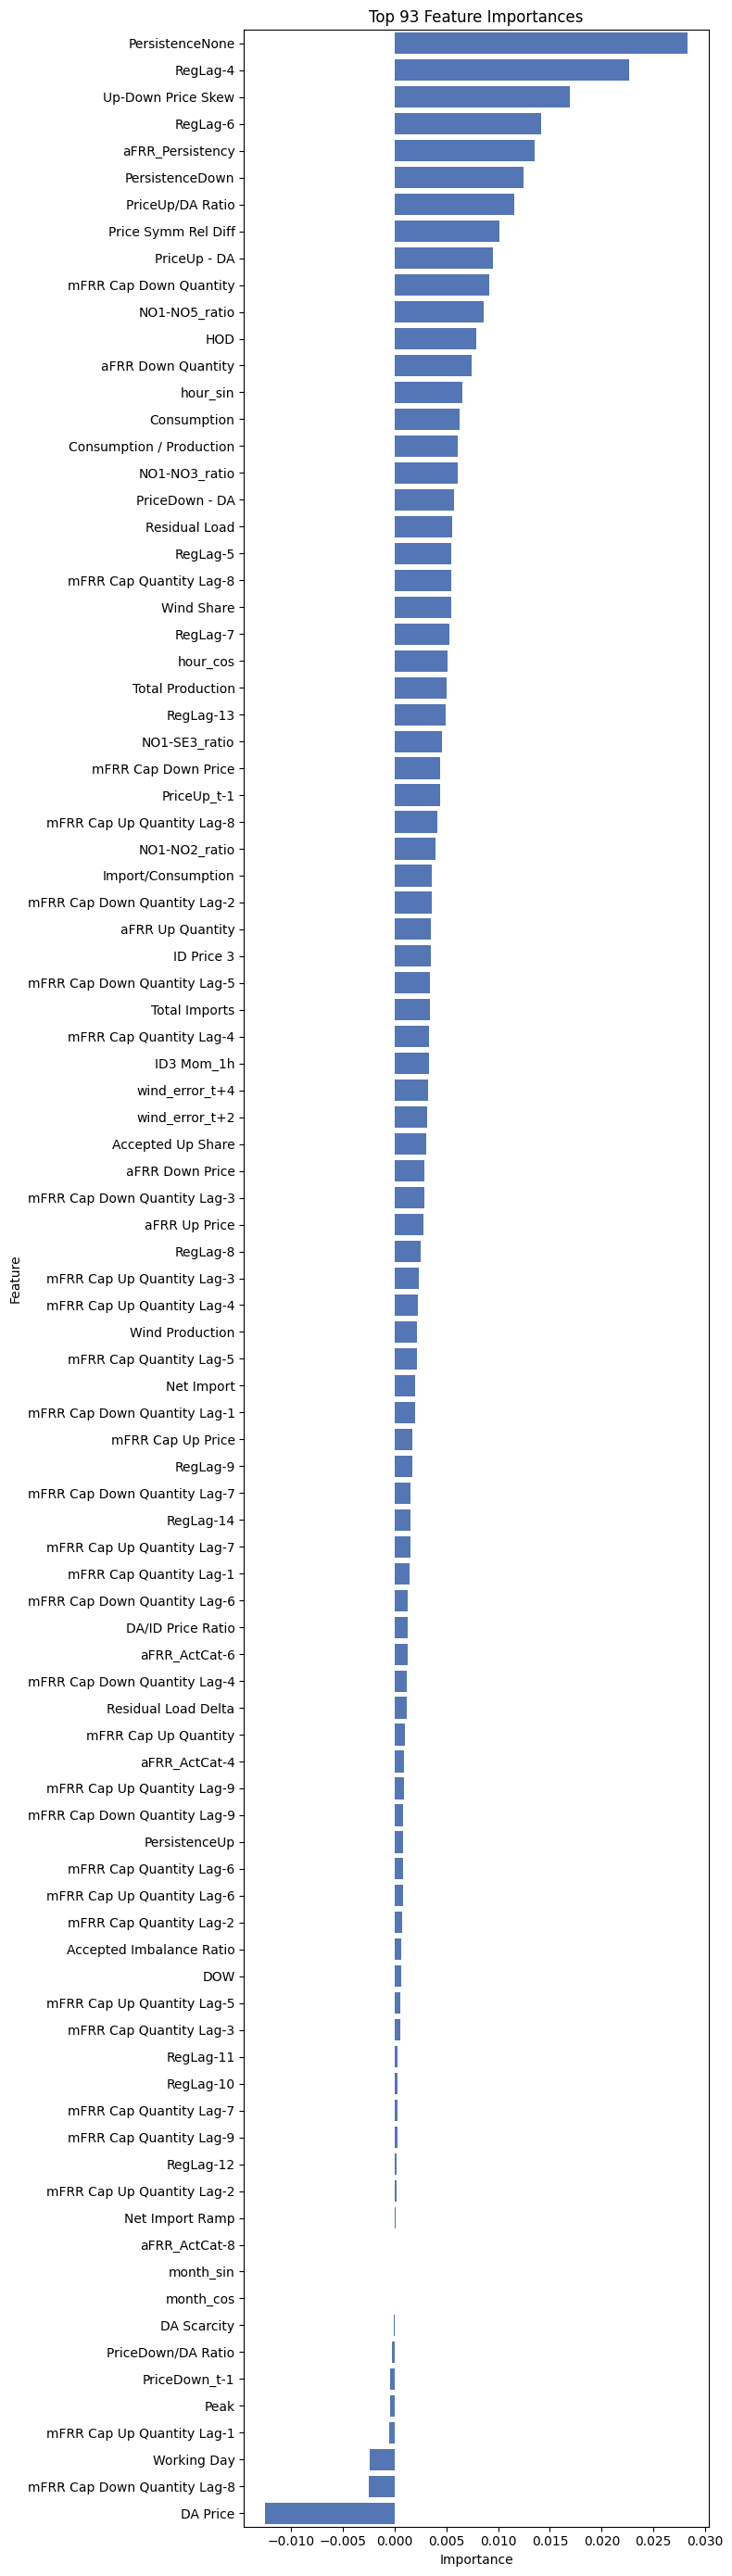

In [12]:
# 16. LightGBM-only HPO on subset (verify only GBM models)
lgbm_hpo_subset_cfg = base_common(area='NO1')
lgbm_hpo_subset_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'lgbm_only_subset_hpo'),
    time_limit=900,
    presets='best_quality',
    model_preset='lgbm_only',
    hpo_trials=4,
    hpo_searcher='random',
    hpo_scheduler='local',
    data_start='2025-03-04',
))
metrics = run_training('LGBM ONLY HPO(4) SUBSET CHECK', **lgbm_hpo_subset_cfg)
# Show trained models
pred = TabularPredictor.load(lgbm_hpo_subset_cfg['output_dir'])
print('Models:', pred.model_names())

In [ ]:
# 17. Inspect features after persistency-interactions disabled run
# Load predictor from cell #15 output_dir and list any Persistency interaction features
from autogluon.tabular import TabularPredictor
p = TabularPredictor.load(xgb_no_inter_subset_cfg['output_dir'])
feat_names = []
try:
    feat_names = list(p.feature_metadata.get_features())
except Exception:
    try:
        feat_names = list(p._learner.feature_metadata_in.get_features())
    except Exception:
        try:
            feat_names = list(p._learner.features)
        except Exception:
            feat_names = []
print('Total features:', len(feat_names))
bad = [f for f in feat_names if (' x Persistency' in f) or ('Persistency x ' in f) or (' x PersistencyDown' in f) or ('PersistencyDown x ' in f)]
print('Persistency-interaction features found:', bad)

--- Reloading project modules ---
Reloaded: preprocess, features, hyperparameters, train
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
mFRR capacity data shape: (64317, 31)
flows shape: (67584, 8)
Number of NaNs before dropna: 139412
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)


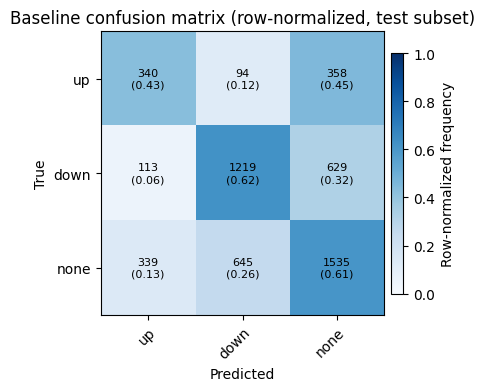


Conditional probabilities P(RegClass+4 = y | RegLag-4 = x) [test subset]
RegClass+4 (target)     up   down   none
RegLag-4 (given)                        
-1                    4.80  62.26  32.94
 0                   14.20  24.94  60.86
 1                   42.93  14.27  42.80


In [ ]:
# 18. Baseline: last-observed-class (RegClass+4 = RegClass-4) + conditional probs
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Reload preprocessing to ensure we use the latest pipeline
reload_all()
import src.data.preprocess as dp
from src.data.preprocess import Config

# Build full dataset by loading the cached preprocessed DataFrame (or build it if cache missing)
cfg = Config()
df_full = dp.preprocess_all(cfg=cfg, cache_path=str(CACHE_NO1))

# Restrict to data from 4th March 2025 until latest available
df_full = df_full.loc['2025-03-04':]
print('Using data range:', df_full.index.min(), '->', df_full.index.max(), 'rows =', len(df_full))

# Split into train/val/test by time order using 0.6/0.2/0.2 fractions
n = len(df_full)
val_start = int(n * 0.6)
test_start = int(n * 0.8)
df_val = df_full.iloc[val_start:test_start]
df_eval = df_full.iloc[test_start:]
print('Validation subset rows =', len(df_val))
print('Test subset rows =', len(df_eval))

label_col = 'RegClass+4'
cond_col = 'RegLag-4'   # condition on previous numeric direction {-1,0,1}
baseline_col = 'RegLag-4'  # numeric {-1,0,1} from mFRR; map to classes

for col in [label_col, cond_col, baseline_col]:
    if col not in df_full.columns:
        raise KeyError(f'Missing required column {col} in df.')

# Map numeric RegLag-4 back to class labels used by RegClass+4
dir_to_class = {1: 'up', -1: 'down', 0: 'none'}

def evaluate_subset(df_subset, subset_name):
    """Evaluate naive baseline on a given subset and print report."""
    y_true_subset = df_subset[label_col].astype(str)
    lag_numeric_subset = df_subset[baseline_col]
    y_pred_subset = lag_numeric_subset.map(dir_to_class).astype(str)
    print(f"\n=== {subset_name} subset ===")
    print('Rows =', len(df_subset))
    print(classification_report(y_true_subset, y_pred_subset))
    return y_true_subset, lag_numeric_subset, y_pred_subset

# Evaluate on full dataset, validation (0.6–0.8 fraction) and test (last 20%) subsets
_y_true_full, _lag_full, _y_pred_full = evaluate_subset(df_full, 'Full (all rows from 2025-03-04)')
y_true_val, lag_val, y_pred_val = evaluate_subset(df_val, 'Validation (0.6–0.8 fraction)')
y_true, lag_numeric, y_pred = evaluate_subset(df_eval, 'Test (last 20%)')

# Confusion matrix (counts and row-normalized) for the test subset
labels = ['up', 'down', 'none']
cm = confusion_matrix(y_true, y_pred, labels=labels)
cm_sum = cm.sum(axis=1, keepdims=True)
cm_norm = cm.astype(float) / cm_sum
cm_norm = pd.DataFrame(cm_norm, index=labels, columns=labels).fillna(0.0).values

# Plot a single, clean confusion-matrix heatmap (row-normalized)
fig, ax = plt.subplots(figsize=(4.5, 4.0))
im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues', vmin=0.0, vmax=1.0)
# Slightly shrink the colorbar so it does not exceed the axes height
cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('Row-normalized frequency')

ax.set_title('Baseline confusion matrix (row-normalized, test subset)')
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Annotate each cell with count and normalized value
for i in range(len(labels)):
    for j in range(len(labels)):
        count = cm[i, j]
        frac = cm_norm[i, j]
        text = f"{count}\n({frac:.2f})"
        ax.text(j, i, text, ha='center', va='center', color='black', fontsize=8)

fig.tight_layout()
plt.show()

# Conditional probabilities: P(RegClass+4 = y | RegLag-4 = x) on the test subset
print('\nConditional probabilities P(RegClass+4 = y | RegLag-4 = x) [test subset]')
prev_dir = lag_numeric
valid_dir_values = [-1, 0, 1]
mask = prev_dir.isin(valid_dir_values) & y_true.isin(['up', 'down', 'none'])

# Crosstab over numeric RegLag-4 vs class label
ct = pd.crosstab(prev_dir[mask], y_true[mask], rownames=['RegLag-4 (given)'], colnames=['RegClass+4 (target)'])
row_perc = ct.div(ct.sum(axis=1), axis=0) * 100
row_perc = row_perc.reindex(index=valid_dir_values, columns=['up', 'down', 'none'])
print(row_perc.round(2))

In [3]:
# 19. AutoGluon best_quality ensemble from 2025-03-04 (NO1)
ag_ens_cfg = base_common(area='NO1')
ag_ens_cfg.update(dict(
    output_dir=str(MODELS_DIR / 'ag_best_quality_ensemble_from_20250304'),
    time_limit=7200,  # long time limit (2 hours); adjust as needed
    presets='best_quality',
    # Let train_and_evaluate map 'auto' to its stacking-friendly preset
    model_preset='auto',
    data_start='2025-03-04',
    # Enable AutoGluon-style ensembling (bagging + simple stacking)
    num_bag_folds=5,
    num_stack_levels=1,
    hpo_trials=0,
    hpo_searcher='random',
    hpo_scheduler='local',
))

# Uncomment to run
run_training('AG best_quality ensemble NO1 from 2025-03-04', **ag_ens_cfg)

=== Run: AG best_quality ensemble NO1 from 2025-03-04 ===
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
mFRR capacity data shape: (64317, 31)
flows shape: (67584, 8)
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 8)
mFRR capacity data shape: (64317, 31)
fl

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.27 GB / 13.85 GB (16.4%)
Disk Space Avail:   351.38 GB / 952.62 GB (36.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       2.27 GB / 13.85 GB (16.4%)
Disk Space Avail:   351.38 GB / 952.62 GB (36.9

Number of NaNs before dropna: 139412
Final preprocessed DataFrame shape: (63311, 100)
Dataset splits: train=37986, val=12662, test=12663 (total=63311)
Applied dataset start filter: from 2025-03-04 -> rows: 26360 (train 15816, val 5272, test 5272)
Last timestamp in dataset: 2025-12-03 14:45:00


Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\ag_best_quality_ensemble_from_20250304"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\ag_best_quality_ensemble_from_20250304"
Train Data Rows:    15816
Train Data Columns: 99
Tuning Data Rows:    5272
Tuning Data Columns: 99
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
Cannot interpret 'Int8Dtype()' as a data type
	Available Memory:                

KeyboardInterrupt: 